**Я выбрал 2 сценарий и датасэт "carvana"**

In [ ]:
import pandas as pd
import numpy as np
import torch
import copy
import time
import os
import cv2
import torchvision.transforms.functional as TF
import random

from tqdm import tqdm
from torchvision import models
from torchvision import transforms
from sklearn.metrics import roc_auc_score, f1_score
from torch import nn
from PIL import Image

from matplotlib import pyplot as plt

SEED=np.random.seed(42)

Decode masks function:

In [ ]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

Let's look at our data and split it to train and validation:

In [ ]:
data_list=pd.read_csv('C:/Users/9dern/Google Drive/train_masks.csv/train_masks.csv')
print(data_list.head(), '\n', data_list.shape)

img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716... 
 (5088, 2)


In [ ]:
data_train=data_list[:4000]
data_test=data_list[4000:]

Dataloader:

In [ ]:
def batch_generator(phase, data_tr, data_val, batch_size=10, num_batches=100):
  if phase == 'train':
      data = data_tr
  else:
      data = data_val
    
  # Shuffle our data list
  train_list = (data.iloc[np.random.permutation(len(data))]).reset_index(drop=True)

  for batch in range(num_batches):
      for size in range(batch_size):

        index = batch * batch_size + size # Index of step
        imag, mask_rle = train_list.iloc[index] 
        
        # Read the photo, decode and transform mask into an image, 
        # so that we can use Torch transforms on the mask.
        image = Image.open('C:/Users/9dern/Google Drive/train/'+ imag)
        mask_rle = rle_decode(mask_rle) #умножить на 255 если для градиента
        mask_rle = mask_rle
        topil = transforms.ToPILImage()
        mask = topil(mask_rle)

        # Resize
        resize = transforms.Resize(size=(250, 250))
        image = resize(image)
        mask = resize(mask)

        if phase == 'train':
          # Random crop
          i, j, h, w = transforms.RandomCrop.get_params(
                          image, output_size=(226, 226))
          image = TF.crop(image, i, j, h, w)
          mask = TF.crop(mask, i, j, h, w)

          # Random horizontal flipping
          if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

          # Random vertical flipping
          if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        else:
          CentralCrop = transforms.CenterCrop(226)
          image = CentralCrop(image)
          mask = CentralCrop(mask)
        
        # Transform to tensor
        image = TF.to_tensor(image)
        #mask = TF.to_tensor(mask) #если нужно с градиентом

        # А этим 2 стрчоки тогда закоментить
        mask = torch.from_numpy(np.array(mask)).float()
        mask = mask.unsqueeze(0)

        tr_im = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        image = tr_im(image)
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        # Stack batch
        if size == 0: 
            x_batch = image
            y_batch = mask
        else:
            x_batch = torch.cat((x_batch, image),0)
            y_batch = torch.cat((y_batch, mask),0)

        yield x_batch, y_batch


In [ ]:
for x,y in batch_generator('val',data_train,data_test, batch_size=4, num_batches=1):
  test=1
y.shape

torch.Size([4, 1, 226, 226])

Пример данных с градиентом, описание зачем это будет ниже

In [ ]:
np.unique(y)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

That's "green gradient" on the pick

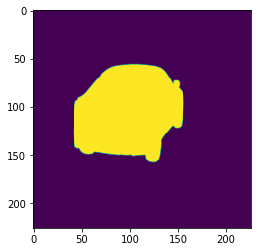

In [ ]:
plt.imshow((y[1,:].permute(1,2,0).numpy())[...,0])

Пример без градиента, как для DICE

In [ ]:
for x,y in batch_generator('val',data_train,data_test, batch_size=4, num_batches=1):
  test=1
y.shape

torch.Size([4, 1, 226, 226])

In [ ]:
np.unique(y)

array([0., 1.], dtype=float32)

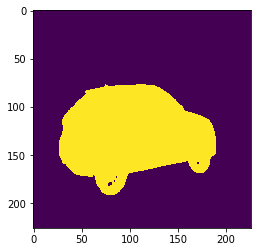

In [ ]:
plt.imshow((y[1,:].permute(1,2,0).numpy())[...,0])

**Важно!**
Т.к. я очень "внимательно" прочитал задание, изначально я сделал серии эксприментов с разными функциями потерь, и тольео сегодня(день сдачи) я прочитал о том что надо было сдеать IoU как минимум. Код уже идет изменненый с IoU как метрика вычесления точности и DICE функцией потерь, но результаты с этими параметрами будут в самом конце, а сначала то что я сделал изначально.

A general function to train a model

In [ ]:
def train_model(model, criterion, optimizer, data_tr, data_val, num_epochs=3, batch_size=20,num_batches=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_acc = 0.0
    val_acc_history = []
    val_loss_history =[]
    # Initialize the log file for training and testing loss and metrics
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataset_sizes = batch_size*num_batches
            else:
                model.eval()   # Set model to evaluate mode
                dataset_sizes = batch_size*num_batches

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in batch_generator(phase, data_tr, data_val, batch_size,num_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out=model(inputs)
                    outputs = out['out']
                    aux_outputs = out['aux']

                    loss = dice(outputs, labels)

                    """остальные опыты делал учитывая аукс лосс,
                     с дайсом уходит в нан после нескольких эпох"""
                    #loss2 = criterion(aux_outputs, labels)
                    #loss = loss1 + 0.4*loss2
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    _, preds = torch.max(outputs, 1)

                running_loss += loss.item()
                #running_corrects += torch.sum(preds == labels.data)
                #IoU
                """так как модель выдает вероятность принадлежности к классу, сначала
                я приведу оба тензора к булевским массивам и потом уже сравню"""
                target=labels.squeeze(1)>0.5
                predict=outputs.squeeze(1)>0.5
                iou=(((predict&target).sum()).item() /((predict | target).sum()).item())
                running_corrects += iou              
              
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

DeeplabHead without adaptive pooling


```
# из-за адаптивного пулинга вечно вылезала ошибка, пришлось перебирать голову что бы ошибка ушла
```



In [ ]:
class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(DeepLabHead, self).__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
            nn.Sigmoid() #Добавим активацию - сигмоиду
        )

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)

class ASPPConv2(nn.Sequential): #Бывший слой адаптивного пулинга, просто вырезал его, сделав обычный конв слой 🤷‍♀️🤷‍♀️🤷‍♀️
    def __init__(self, in_channels, out_channels,):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv2, self).__init__(*modules)



class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rate1, rate2, rate3 = tuple(atrous_rates)
        modules.append(ASPPConv(in_channels, out_channels, rate1))
        modules.append(ASPPConv(in_channels, out_channels, rate2))
        modules.append(ASPPConv(in_channels, out_channels, rate3))
        modules.append(ASPPConv2(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))
    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


Function to create model

In [ ]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Sigmoid activation after the last convolution layer
    model.classifier = DeepLabHead(2048, 1)
    # Set the model in training mode
    model.train()
    return model

In [ ]:
model = createDeepLabv3()

Edit aux classifier too

In [ ]:
conv=torch.nn.Conv2d(
    in_channels=256,
    out_channels=1,
    kernel_size=(1, 1),
    stride=(1, 1)
                ).cuda() # change output channels to 1

#if need sigmoid as last layer
#sigma=torch.nn.Sigmoid()

model.aux_classifier[4]=conv
#model.aux_classifier=nn.Sequential(*list(modelz.aux_classifier)+[sigma]) 

Parameters

In [ ]:
# Loss function
criterion = nn.BCEWithLogitsLoss()
# Optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
                            

Я провел серию тренировок с разными параметрами(learning rate = 1е-4, если не указан):
1. Бинарная кросс энтропия (BCE) и соотвественно добавил на конец классификаторов сигмоиды
2. Логистическая бинарная кросс энтропия (LBCE)
3. LBCE с лернинг рейтом 1е-5
4. LBCE с маской со значениями 0 и 1


> При аугментациях я умножал маску на 255, получая тензор из 0 и 255, проводил необходимые изменения и переводил в тензор с помощью torch.to_tensor,  данная операция не просто делит на 255 и переводит в значения с плавающей  точкой, а делает градиент в месте перехода (автомобиль-бэкграунд). Тогда получается тензор с уникальными значениями [0.0, 0.01...0.99, 1.0] пример  отсавил выше где батч генератор.
Для Dice использую только 1 и 0 поэтому счейчас батч генератор выдает такой диапазон.





In [ ]:
trained_model,acc,lss = train_model(model, criterion, optimizer, data_train,data_test, num_epochs=20, batch_size=4,num_batches=250)

Полученые результаты свел в таблицу, в хороших моделях сделал больше эпох.

Сразу напишу функцию визуализации данных и загрузки натренированных моделей, что бы код не мешал повествованию

In [ ]:
def test_model(model, number=0, way='C:/Users/9dern/Google Drive/test/'):
    data=pd.read_csv('C:/Users/9dern/Google Drive/test/test.csv')
    img_name = data.iloc[number,0]

    imagea = Image.open(way + img_name)
    #imagea = Image.open('/content/drive/My Drive/IMG_20190831_002834.jpg')
    h,w,c=np.array(imagea).shape
    resize = transforms.Resize(size=(250, 250))
    imager = resize(imagea)

    trf = transforms.Compose([#transforms.Resize(250),
                              transforms.ToTensor(), 
                              transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                              std = [0.229, 0.224, 0.225])])
    
  
    image= trf(imager)
    image = image.unsqueeze(0).cuda()
    mas = model(image)['out']
    
    masks = mas.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    masks = 1/(1 + np.exp(-masks)) #sigmoid for BCEWithLogistLoss
    mask = cv2.resize(masks,(w,h))
    imager = cv2.resize(np.array(imager), (w, h))
    
    fig, axs = plt.subplots(1, 3, figsize=(22,5))

    #plot the original data
    axs[0].imshow(imagea,aspect=1) 
    axs[0].axis('off')
    axs[0].set_title('Image')

    #plot the mask
    axs[1].imshow((mask>0.5),aspect=1)
    axs[1].axis('off')   
    axs[1].set_title('Mask')
    
    #plot image and add the mask
    axs[2].imshow(imager)
    axs[2].imshow((mask>0.5), alpha = 0.5, cmap = "Reds")
    axs[2].axis('off')   
    axs[2].set_title('Image with mask overlay')

    # set suptitle
    #plt.suptitle('Image with mask')
    return plt.show()

In [ ]:
def load_model(number = 2):
    if number == 1:
      model = torch.load('/content/drive/My Drive/Model_BCE_Sigm.pth')
    elif number == 2:
      model = torch.load('C:/Users/9dern/Google Drive/Segmentation/Model_2.pth')
    elif number == 3:
      model = torch.load('/content/drive/My Drive/Model_3.pth')
    else:
      model = torch.load('/content/drive/My Drive/Model_4.pth')
    model.eval().cuda()
    return model  

In [ ]:
model4 = load_model(4)
model1 = load_model(1)
model2 = load_model(2)
model3 = load_model(3)

In [ ]:
model2 = load_model(2)

C:\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torchvision.models._utils.IntermediateLayerGetter' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Anaconda3\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'torchvision.models.resnet.Bottleneck' has changed. you can retrieve the original source code by accessing the object's source attribute or set

Теперь графики от полученных результатов:

In [ ]:
result=data=pd.read_csv('/content/drive/My Drive/results.csv')
result.head()

,1 loss,1 acc,2 loss,2 acc,3 loss,3 acc,4 loss,4 acc
0,0.171782,279207.963,0.181256,281091.0750,0.398137,281172.8679,0.086091,283747.769
1,0.133206,279460.120,0.130678,278297.2964,0.338455,281554.5214,0.064168,283524.488
2,0.126858,279659.508,0.094296,279393.7250,0.295681,281160.6821,0.065812,283518.185
3,0.124516,280018.987,0.082050,280118.4750,0.275486,278836.7643,0.060538,283528.230
4,0.126851,279408.764,0.074159,280545.1500,0.231126,279210.5250,0.057858,283452.624


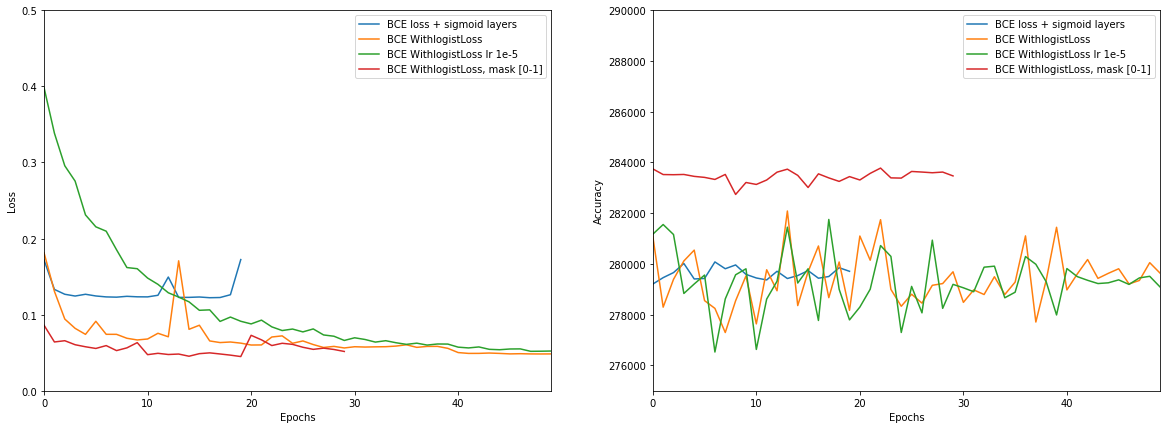

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))
#plt.subplots(figsize=(12,7))
axs[0].plot(result['1 loss'], '-', label='BCE loss + sigmoid layers')
axs[0].plot(result['2 loss'], '-', label='BCE WithlogistLoss')
axs[0].plot(result['3 loss'], '-', label='BCE WithlogistLoss lr 1e-5')
axs[0].plot(result['4 loss'], '-', label='BCE WithlogistLoss, mask [0-1]')
axs[1].plot(result['1 acc'], '-', label='BCE loss + sigmoid layers')
axs[1].plot(result['2 acc'], '-', label='BCE WithlogistLoss')
axs[1].plot(result['3 acc'], '-', label='BCE WithlogistLoss lr 1e-5')
axs[1].plot(result['4 acc'], '-', label='BCE WithlogistLoss, mask [0-1]')
#plt.title('Results')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()
axs[0].set_xlim(0,49)
axs[0].set_ylim(0,0.5)
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_xlim(0,49)
axs[1].set_ylim(275000,290000)
axs[1].legend()
plt.show()

На первый взгляд кажется что лучше всего себя показал LBCE с маской без градиента, но на самом деле, т.к. маска отличается то и расчет точности другой, и такие данные не совсем сопоставимы, на деле качетсво модели оказалось на 3 месте. Самое слабое место зеркала:

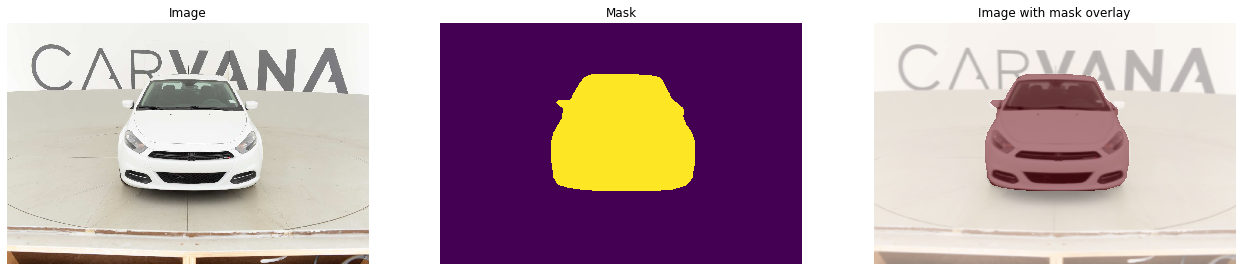

In [ ]:
test_model(model4, number = 31)

BCE с сигмоидами, по идее должна выдать совершенно тоже самое что и LBCE, но на деле она себя проявляет ужасно, не я один с этим столкнулся судя по форумам пайторча. Видимо проблема где-то в функции. Для теста этой модели надо закоментить сигмоиду в функции test_model

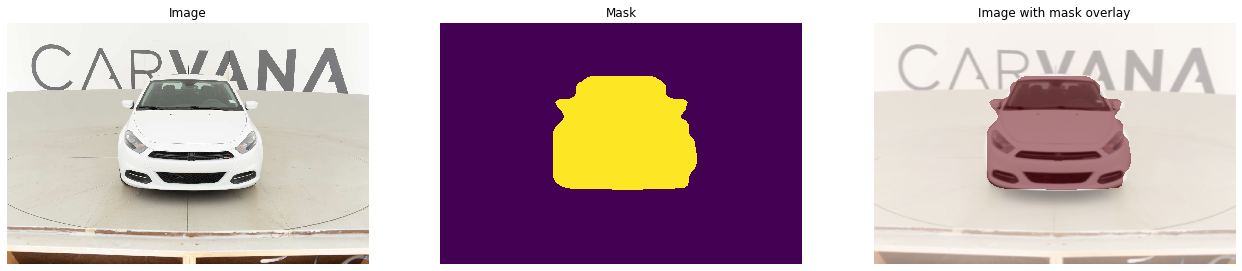

In [ ]:
test_model(model1, number = 31)


И лучше всех себя показали LBCE с градиентной маской, с лернинг рейтом -4 степени чуть лучше, так-что сразу покажу ее

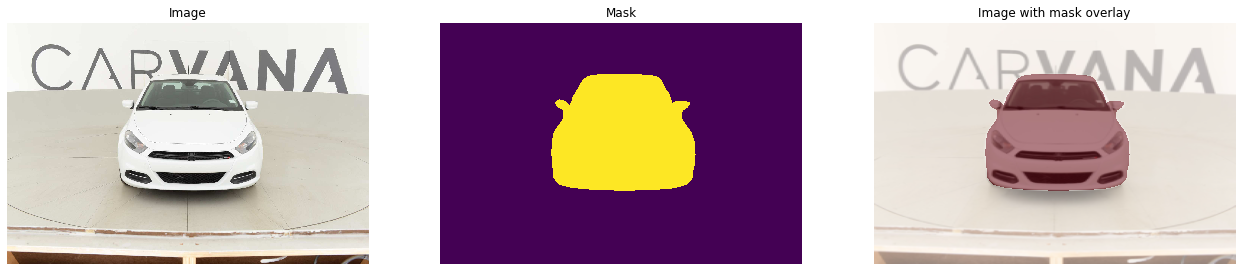

In [ ]:
test_model(model2, number = 31)


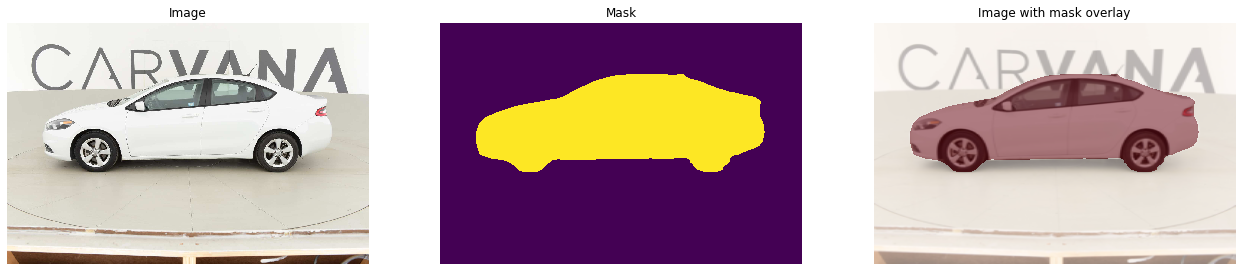

In [ ]:
test_model(model2, number = 33)

Сравним с оригинальной моделью

In [ ]:
original = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True).cuda().eval()

In [ ]:
def test_model_orig(model, number=0, way='/content/drive/My Drive/test/'):
    data=pd.read_csv('/content/drive/My Drive/test/test.csv')
    img_name = data.iloc[number,0]

    imagea = Image.open(way + img_name)
    #imagea = Image.open('/content/drive/My Drive/IMG_20190831_002834.jpg')
    h,w,c=np.array(imagea).shape
            # Resize
    resize = transforms.Resize(size=(250, 250))
    imager = resize(imagea)

    trf = transforms.Compose([#transforms.Resize(250),
                              transforms.ToTensor(), 
                              transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                              std = [0.229, 0.224, 0.225])])
    
  
    image= trf(imager)
    image = image.unsqueeze(0).cuda()
    mas = model(image)['out']
    
    mas = torch.argmax(mas.squeeze(), dim=0).detach().cpu().numpy()

    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (128, 128, 128), (255, 0, 0), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(mas).astype(np.uint8)
    g = np.zeros_like(mas).astype(np.uint8)
    b = np.zeros_like(mas).astype(np.uint8)
  
    for l in range(0, 21):
      idx = mas == l
      r[idx] = label_colors[l, 0]
      g[idx] = label_colors[l, 1]
      b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)

    mask = cv2.resize(rgb,(w,h))
    imager = cv2.resize(np.array(imager), (w, h))
    
    fig, axs = plt.subplots(1, 3, figsize=(22,5))

    #plot the original data
    axs[0].imshow(imagea,aspect=1) 
    axs[0].axis('off')
    axs[0].set_title('Image')

    #plot the mask
    axs[1].imshow((mask),aspect=1)
    axs[1].axis('off')   
    axs[1].set_title('Mask')
    
    #plot image and add the mask
    axs[2].imshow(imager)
    axs[2].imshow((mask), alpha = 0.5, cmap = "Reds")
    axs[2].axis('off')   
    axs[2].set_title('Image with mask overlay')

    # set suptitle
    #plt.suptitle('Image with mask')
    return plt.show()

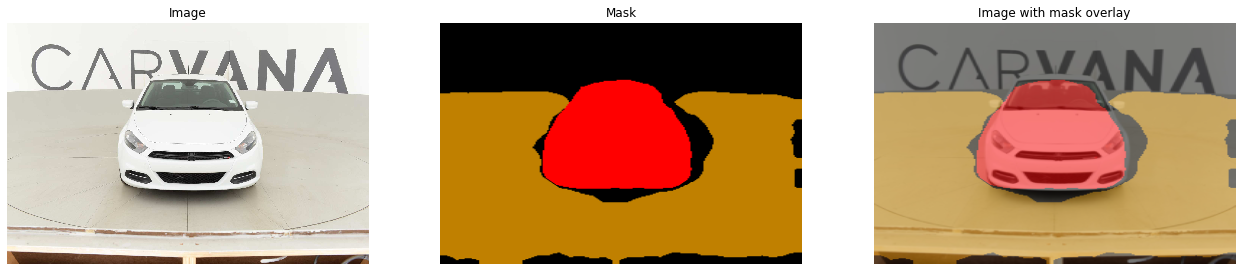

In [ ]:
test_model_orig(original, number = 31)

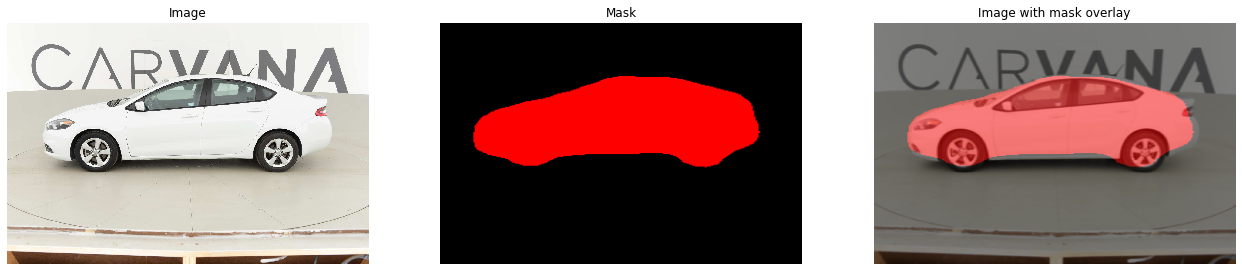

In [ ]:
test_model_orig(original, number = 33)

Желтый - стол 🤷‍♀️. Возьмем еще одну машинку для наглядности и сравним

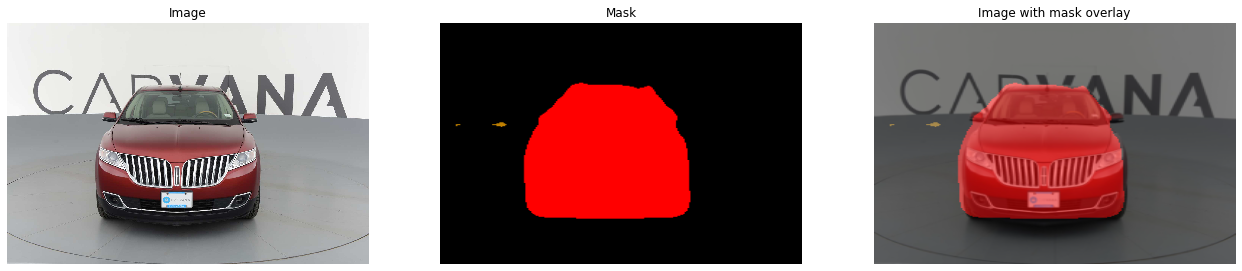

In [ ]:
test_model_orig(original, number = 34)

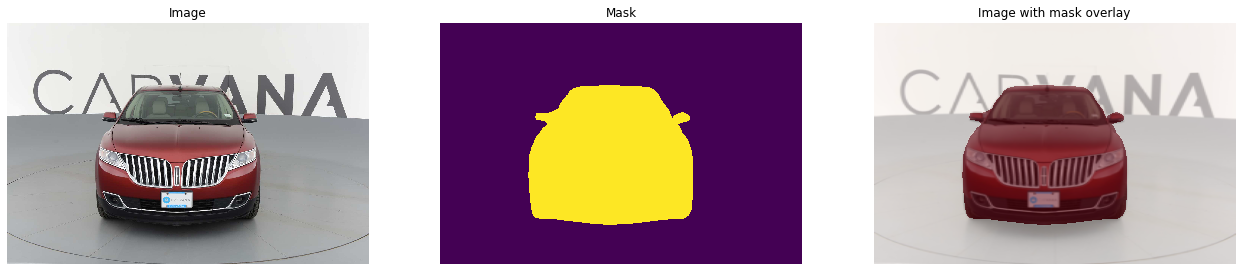

In [ ]:
test_model(model2, number = 34)

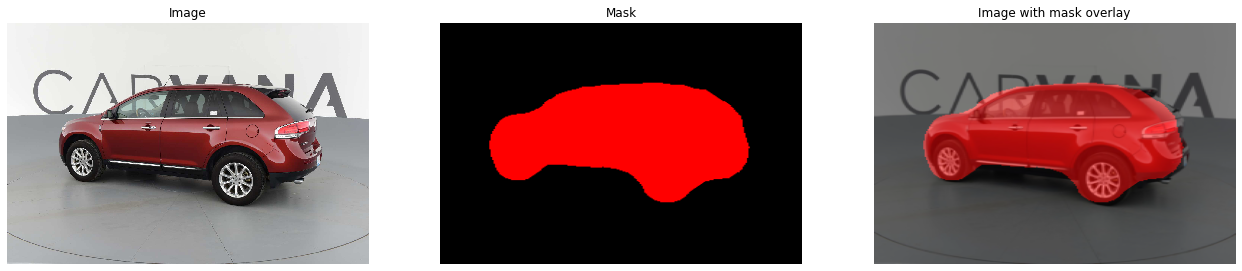

In [ ]:
test_model_orig(original, number = 36)

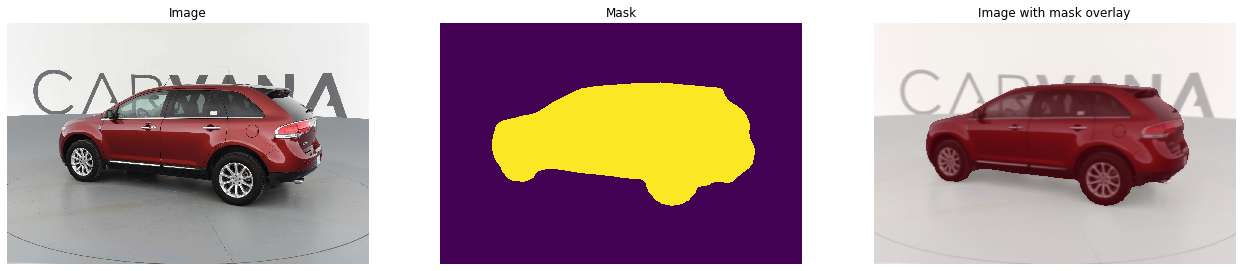

In [ ]:
test_model(model2, number = 36)

**Теперь с IoU и DICE loss**

Dice loss:

In [ ]:
def dice(pred, mask):
    smooth=1
    pred = 1/(1 + torch.exp(-pred)) #перевод предсказаний модели к диапазону 0-1
    pred = pred.squeeze(1).view(-1) # так как класс 1, удаляю ось классов
    mask = mask.squeeze(1).view(-1)
    inter = (pred*mask).sum()
    
    return(1-((2*inter + smooth)/(pred.sum()+mask.sum()+smooth)))

Для тренировки возьму свою пред обученную модель номер 2, то что в модель подается тот же criterion, не важно т.к. изменения в функции трейна

In [ ]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-5)

In [ ]:
trained_model,acc,lss = train_model(model2, 0, optimizer2, data_train,data_test, num_epochs=3, batch_size=6,num_batches=100)

Epoch 1/3
----------
train Loss: 0.0118 Acc: 0.9822
val Loss: 0.0110 Acc: 0.9825

Epoch 2/3
----------
train Loss: 0.0107 Acc: 0.9822
val Loss: 0.0106 Acc: 0.9822

Epoch 3/3
----------
train Loss: 0.0101 Acc: 0.9829
val Loss: 0.0099 Acc: 0.9830

Training complete in 71m 6s
Best val loss: 0.009893
Best val Acc: 0.982970


Полученную модель точно нельзя считать обученной до конца, как минимум валидационная часть изображений в каждой эпохе разная, что не может дать однозначной оценки текущих весов. Но прогнать полный цикл я уже не успеваю. Но хоть посмотрим что получилось:

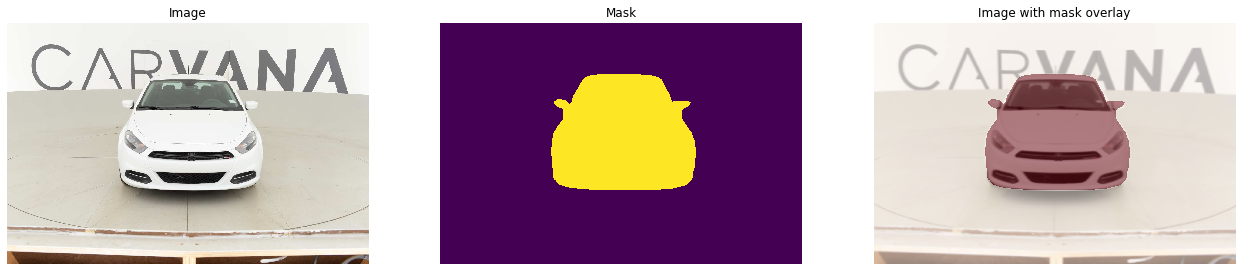

In [ ]:
test_model(model2, number = 31)

Функция для сохранения моделей:

In [ ]:
def save_model(model):
    torch.save(model, 'C:/Users/9dern/Google Drive/Segmentation/extralastez1.pth')

In [ ]:
save_model(model2)

C:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DeepLabV3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type IntermediateLayerGetter. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\se

**Выводы**

На данном датасэте сегментация нужна была в рекламных целях, для вырезки автомобиля с фото и размещение его на другом фоне. Раньше этим занимались люди, теперь соотвественно данная операция происходит в разы быстрее и без участия человека.
Сегментация на 1 класс так же может быть использованна во многих областях, при необходимости выделить единственно значимый объект, например: раковые клетки со снимка, трещены на асфальте, дороги со спутниковых снимков, очаги пожаров и т.д.
Может применяться на производстве, например для контроля брака - выявление трещин на экранах телефонов\компьютеров как пример.